In [49]:
import os
from zlib import crc32
import pandas as pd
import tarfile
import urllib
import numpy as np
import sklearn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
plt.style.use('seaborn')

In [50]:
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

In [51]:
def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    os.makedirs(housing_path, exist_ok=True)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [52]:
def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [53]:
fetch_housing_data()
housing = load_housing_data()

In [54]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [55]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [56]:
housing['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [57]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


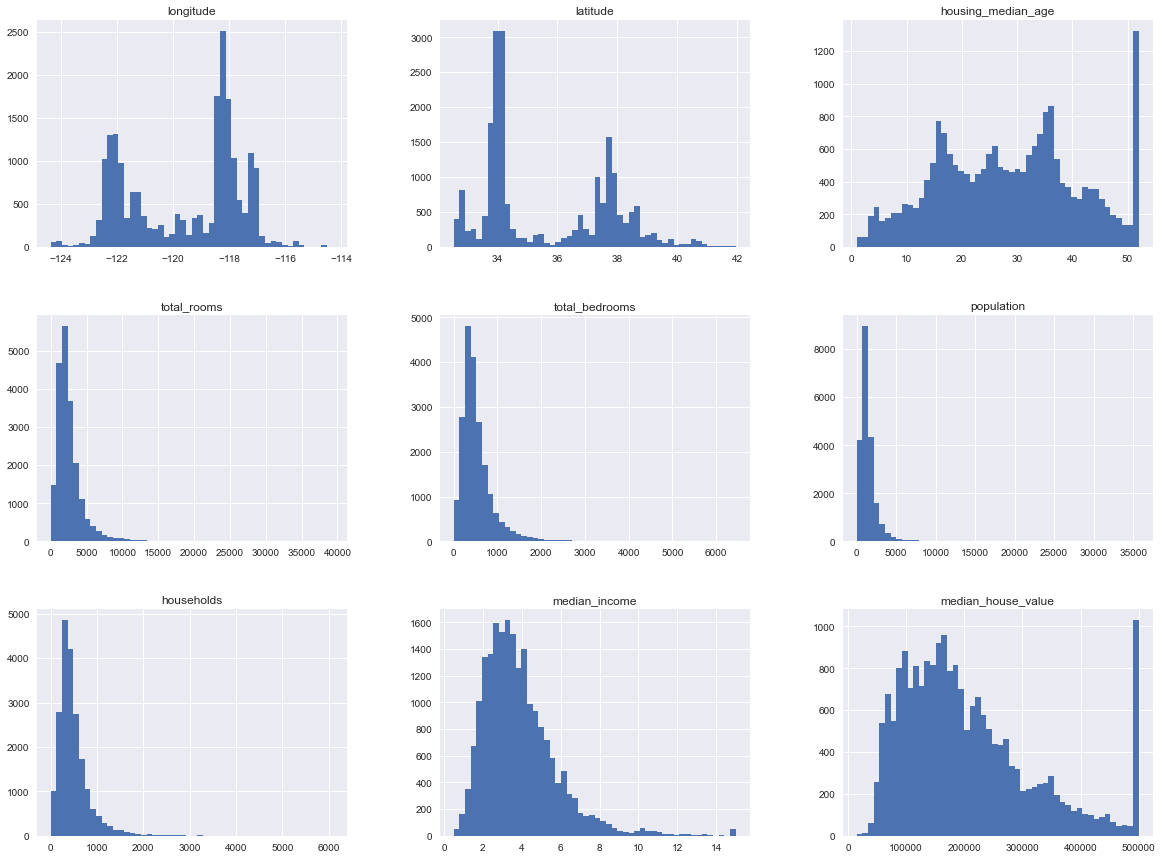

In [58]:
housing.hist(bins=50, figsize=(20,15))
plt.show()

In [59]:
def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [60]:
def test_set_check(identifier, test_ratio):
    return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2**32
def split_train_test_by_id(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

In [61]:
housing_with_id = housing.reset_index() # adds an `index` column
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "index")

In [62]:
housing_with_id["id"] = housing["longitude"] * 1000 + housing["latitude"]
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "id")

In [63]:
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

<AxesSubplot:>

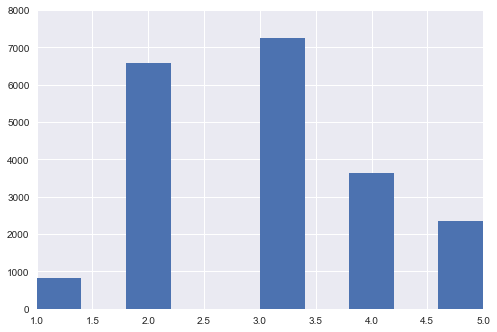

In [64]:
housing['income_category'] = pd.cut(housing['median_income'], bins=[0., 1.5, 3., 4.5, 6., np.inf], labels=[1,2,3,4,5])
plt.xlim((1,5))
plt.ylim((0,8000))
housing['income_category'].hist()

In [65]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing['income_category']):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [66]:
strat_train_set['income_category'].value_counts() / len(strat_train_set)

3    0.350594
2    0.318859
4    0.176296
5    0.114402
1    0.039850
Name: income_category, dtype: float64

In [67]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_category", axis=1, inplace=True)

In [68]:
housing = strat_train_set.copy()

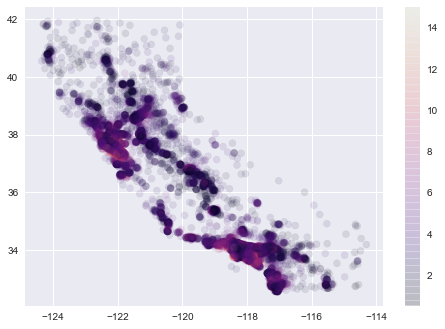

In [69]:
#housing.plot(kind="scatter", x="longitude", y="latitude", c="median_income", cmap='magma', alpha=.1)
plt.scatter(x=housing.longitude, y=housing.latitude, c=housing.median_income, cmap='magma', alpha=.1)
plt.colorbar()

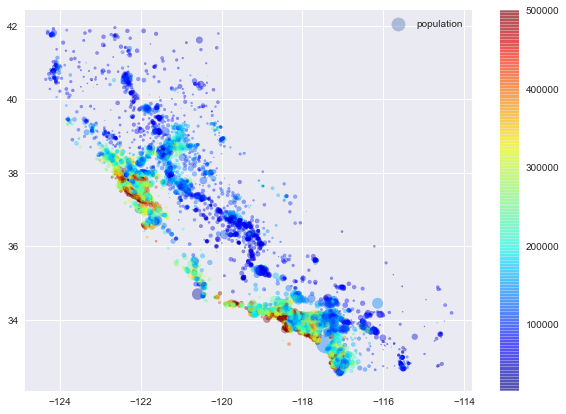

In [70]:
plt.figure(figsize=(10,7))
plt.scatter(x=housing.longitude, y=housing.latitude, c=housing.median_house_value,
           s=housing.population/100, cmap='jet', alpha=.4, label='population')
plt.colorbar()
plt.legend();

In [71]:
corr_matrix = housing.corr()

In [72]:
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

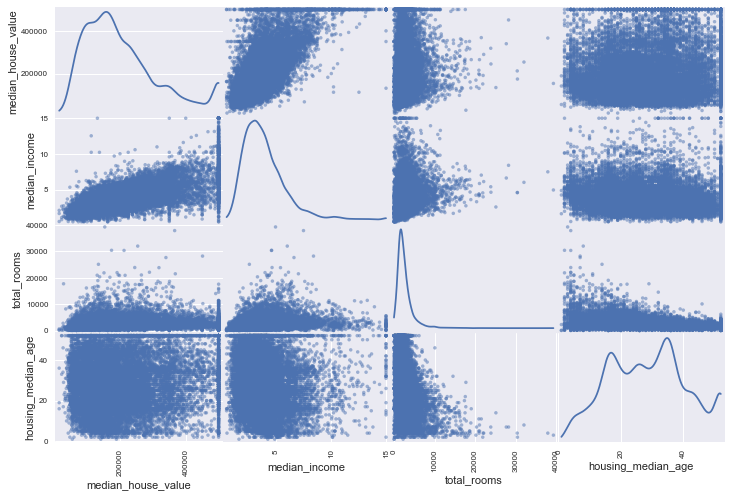

In [73]:
from pandas.plotting import scatter_matrix

attributes = ['median_house_value', 'median_income', 'total_rooms', 'housing_median_age']

scatter_matrix(housing[attributes], figsize=(12, 8), diagonal='kde');

<AxesSubplot:xlabel='median_income', ylabel='median_house_value'>

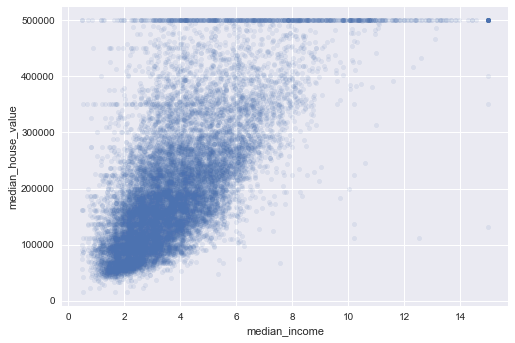

In [74]:
housing.plot(kind="scatter", x="median_income", y="median_house_value", alpha=.1)

In [75]:
housing['rooms_per_household'] = housing['total_rooms'] / housing['households']
housing['bedrooms_per_room'] = housing['total_bedrooms'] / housing['total_rooms']
housing['population_per_household'] = housing['population'] / housing['households']

In [76]:
corr_matrix = housing.corr()

In [77]:
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

In [78]:
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

In [79]:
housing.dropna(subset=['total_bedrooms']) # option 1: get rid of the features in which there is a N/A of "total_bedrooms"

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042,<1H OCEAN
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214,<1H OCEAN
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621,NEAR OCEAN
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839,INLAND
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347,<1H OCEAN
...,...,...,...,...,...,...,...,...,...
6563,-118.13,34.20,46.0,1271.0,236.0,573.0,210.0,4.9312,INLAND
12053,-117.56,33.88,40.0,1196.0,294.0,1052.0,258.0,2.0682,INLAND
13908,-116.40,34.09,9.0,4855.0,872.0,2098.0,765.0,3.2723,INLAND
11159,-118.01,33.82,31.0,1960.0,380.0,1356.0,356.0,4.0625,<1H OCEAN


In [80]:
housing.drop('total_bedrooms', axis=1) # option 2: drop the entire total_bedrooms column

,longitude,latitude,housing_median_age,total_rooms,population,households,median_income,ocean_proximity
17606,-121.89,37.29,38.0,1568.0,710.0,339.0,2.7042,<1H OCEAN
18632,-121.93,37.05,14.0,679.0,306.0,113.0,6.4214,<1H OCEAN
14650,-117.20,32.77,31.0,1952.0,936.0,462.0,2.8621,NEAR OCEAN
3230,-119.61,36.31,25.0,1847.0,1460.0,353.0,1.8839,INLAND
3555,-118.59,34.23,17.0,6592.0,4459.0,1463.0,3.0347,<1H OCEAN
...,...,...,...,...,...,...,...,...
6563,-118.13,34.20,46.0,1271.0,573.0,210.0,4.9312,INLAND
12053,-117.56,33.88,40.0,1196.0,1052.0,258.0,2.0682,INLAND
13908,-116.40,34.09,9.0,4855.0,2098.0,765.0,3.2723,INLAND
11159,-118.01,33.82,31.0,1960.0,1356.0,356.0,4.0625,<1H OCEAN


In [81]:
median = housing['total_bedrooms'].median() # option 3: calculate the medidan of total_bedrooms (the value separating the 
############################################# higher and the lower part of the column
housing['total_bedrooms'].fillna(median, inplace=True)

In [82]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='median')
housing_num = housing.drop('ocean_proximity', axis=1) # simple imputer only works in NUMERICAL attributes

imputer.fit(housing_num)
print(imputer.statistics_)

X = imputer.transform(housing_num)
housing_sImputer = pd.DataFrame(X, columns=housing_num.columns, index=housing_num.index)

[-118.51     34.26     29.     2119.5     433.     1164.      408.
    3.5409]


In [83]:
housing_cat = housing[["ocean_proximity"]]

In [84]:
### Encode non-numerical attributes to numbers based on the categorical properties of them ###
from sklearn.preprocessing import OrdinalEncoder 
ordinal_encoder = OrdinalEncoder()
housing_cat_ordinally_encoded = ordinal_encoder.fit_transform(housing_cat)
print(housing_cat_ordinally_encoded[:10])

[[0.]
 [0.]
 [4.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]]


In [85]:
### Encode non-numerical attributes to one-hot attributess ###
from sklearn.preprocessing import OneHotEncoder
onehot_encoder = OneHotEncoder()
housing_cat_onehotly_encoded = onehot_encoder.fit_transform(housing_cat)
print(housing_cat_onehotly_encoded[:10])
print(type(housing_cat_onehotly_encoded)) # type of scipy sparse matrix ---> less space needed

  (0, 0)	1.0
  (1, 0)	1.0
  (2, 4)	1.0
  (3, 1)	1.0
  (4, 0)	1.0
  (5, 1)	1.0
  (6, 0)	1.0
  (7, 1)	1.0
  (8, 0)	1.0
  (9, 0)	1.0
<class 'scipy.sparse.csr.csr_matrix'>


In [86]:
print(ordinal_encoder.categories_)
print(onehot_encoder.categories_)

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
      dtype=object)]
[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
      dtype=object)]


In [87]:
### Create a custom transformer ###
from sklearn.base import BaseEstimator, TransformerMixin
rooms_ix, bedrooms_ix, population_ix, households_ix = 3,4,5,6

In [88]:
class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_rooms=True): # no *args or ##kargs
        self.add_bedrooms_per_rooms = add_bedrooms_per_rooms
    def fit(self, X, y=None):
        return self # nothing else to do
    def transform(self, X):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_rooms:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

In [89]:
attr_adder = CombinedAttributesAdder(add_bedrooms_per_rooms=False)
housing_extra_attributes = attr_adder.transform(housing.values)

In [98]:
list(housing.columns)

['longitude',
 'latitude',
 'housing_median_age',
 'total_rooms',
 'total_bedrooms',
 'population',
 'households',
 'median_income',
 'ocean_proximity']

In [99]:
pd.DataFrame(housing_extra_attributes, columns=list(housing.columns)+['rooms_per_household', 'population_per_household'], index=housing.index).head(5)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,rooms_per_household,population_per_household
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042,<1H OCEAN,4.625369,2.094395
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214,<1H OCEAN,6.00885,2.707965
14650,-117.2,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621,NEAR OCEAN,4.225108,2.025974
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839,INLAND,5.232295,4.135977
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347,<1H OCEAN,4.50581,3.047847
